In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import json
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECK_DIR
from cot.models import TransformerConfig, Transformer

In [72]:
all_configs = []
with open(CHECK_DIR / 'parity.jsonl', 'r') as f:
    json_str = f.read()
    json_objs = json_str.split('}\n')
    for json_obj in json_objs:
        if json_obj:
            all_configs.append(json.loads(json_obj + '}'))

In [74]:
for config in all_configs:
    data_dir = Path(config['data_dir'])
    problem = config['problem']
    n_len = int(config['n_len'])
    split_probas = float(config['split_probas'])
    n_data_per_len = int(config['n_data_per_len'])
    zipf_offset = float(config['zipf_offset'])
    zipf_coef = float(config['zipf_coef'])
    emb_dim = int(config['emb_dim'])
    emb_dropout = float(config['emb_dropout'])
    n_head = int(config['n_head'])
    n_layer = int(config['n_layer'])
    n_epochs = int(config['n_epochs'])
    batch_size = int(config['batch_size'])
    learning_rate = float(config['learning_rate'])
    check_dir = Path(config['check_dir'])
    eval_freq = int(config['eval_freq'])
    checkpoint_freq = int(config['checkpoint_freq'])
    overwrite_checkpoint = bool(config['overwrite_checkpoint'])
    load_checkpoint = bool(config['load_checkpoint'])

    print(f"{learning_rate=}, {batch_size=}")

    checkpoint = torch.load(check_dir / 'model.pth')

    timestamps = checkpoint['timestamps']
    ind = timestamps != -1
    timestamps = timestamps[ind]

    meaning = checkpoint['meaning']
    evals = checkpoint['evals'][ind]

    eval_dim = evals.shape[1] // 2
    train_evals = evals[:, :eval_dim]
    test_evals = evals[:, eval_dim:]

    min_len = 8
    nd_meaning = np.array(meaning)
    res = np.empty((2, n_len + 1 - min_len), dtype=float)
    for i, eval_prefix in enumerate(['attn0_peaky_thres', 'attn1_peaky_thres']):
        for j, length in enumerate(range(min_len, n_len+1)):
            eval_name = f"{eval_prefix}_{length}"

            ind = np.argmax(np.array(meaning) == eval_name)

            train_res = train_evals[-1, ind]
            test_res = test_evals[-1, ind]
            res[i, j] = test_res

    train_acc = train_evals[-1, min_len-1:n_len].mean()
    test_acc = train_evals[-1, min_len-1:n_len].mean()
    res = res.mean(axis=0)
    print(f"{res.mean():1.0e}, {train_acc:1.0e}, {test_acc:1.0e}")

learning_rate=1.0, batch_size=4096
3e-01, 0e+00, 0e+00
learning_rate=0.001, batch_size=256
4e-01, 1e+00, 1e+00
learning_rate=0.0003, batch_size=256
1e+00, 1e+00, 1e+00
learning_rate=0.003, batch_size=256
6e-02, 2e-01, 2e-01
learning_rate=0.001, batch_size=64
1e-01, 1e+00, 1e+00
learning_rate=0.0003, batch_size=64
8e-01, 1e+00, 1e+00
learning_rate=0.1, batch_size=64
7e-02, 0e+00, 0e+00
learning_rate=0.003, batch_size=64


4e-01, 1e-03, 1e-03
learning_rate=1.0, batch_size=64
0e+00, 0e+00, 0e+00
learning_rate=0.01, batch_size=4096
2e-02, 0e+00, 0e+00
learning_rate=0.01, batch_size=64
2e-01, 0e+00, 0e+00
learning_rate=0.1, batch_size=4096
8e-03, 0e+00, 0e+00
learning_rate=0.0003, batch_size=4096
8e-01, 1e+00, 1e+00
learning_rate=0.003, batch_size=4096
1e-01, 7e-01, 7e-01
learning_rate=0.001, batch_size=4096
5e-01, 1e+00, 1e+00
learning_rate=0.01, batch_size=1024
0e+00, 0e+00, 0e+00
learning_rate=1.0, batch_size=256
2e-03, 0e+00, 0e+00
learning_rate=0.01, batch_size=256
0e+00, 0e+00, 0e+00
learning_rate=0.1, batch_size=256
0e+00, 0e+00, 0e+00
learning_rate=0.0003, batch_size=1024
9e-01, 1e+00, 1e+00
learning_rate=0.003, batch_size=1024
4e-01, 9e-04, 9e-04
learning_rate=0.1, batch_size=1024
3e-02, 0e+00, 0e+00
learning_rate=0.001, batch_size=1024
5e-01, 1e+00, 1e+00
learning_rate=0.003, batch_size=2048
4e-02, 8e-05, 8e-05
learning_rate=1.0, batch_size=2048
0e+00, 0e+00, 0e+00
learning_rate=0.0003, batch_size

## Looking at the evaluation metrics

In [40]:
checkpoint = torch.load(check_dir / 'model.pth')

timestamps = checkpoint['timestamps']
ind = timestamps != -1
timestamps = timestamps[ind]

meaning = checkpoint['meaning']
evals = checkpoint['evals'][ind]

eval_dim = evals.shape[1] // 2
train_evals = evals[:, :eval_dim]
test_evals = evals[:, eval_dim:]

In [46]:
min_len = 8
nd_meaning = np.array(meaning)
res = np.empty((2, n_len - min_len), dtype=float)
for i, eval_prefix in enumerate(['attn0_peaky_thres', 'attn1_peaky_thres']):
    for j, length in enumerate(range(min_len, n_len)):
        eval_name = f"{eval_prefix}_{length}"

        ind = np.argmax(np.array(meaning) == eval_name)

        train_res = train_evals[-1, ind]
        test_res = test_evals[-1, ind]
        res[i, j] = test_res
res = res.mean(axis=0)

In [47]:
print(res)

[1.         1.         1.         0.95454545 0.95833333 0.91695463
 0.79418945 0.68349609]


## Looking at the model attention maps

In [19]:
token_emb = checkpoint['model_state_dict']['embeddings.token_emb.weight'].cpu()
pos_emb = checkpoint['model_state_dict']['embeddings.pos_emb.weight'].cpu()

In [22]:
lengths = list(np.arange(n_len) + 1)

if problem == 'binary-copy':
    testset = BinaryCopy()
elif problem == 'parity':
    testset = Parity()
testset.set_data(lengths, data_type="test")

In [23]:
config = TransformerConfig(
    vocab_size=torch.max(testset.data).item() + 1,
    emb_dim=emb_dim,
    pos_emb=True,
    seq_len=len(testset[0]),
    emb_dropout=0,
    n_head=n_head,
    n_layer=n_layer,
)

model = Transformer(config)
model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device=device)
model.eval()

Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(35, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=5, bias=False)
)

In [24]:
sequence = testset.data
# sequence = sequence.to(device=device, dtype=torch.long)

with torch.no_grad():
    logits, attentions = model(sequence, verbose=True)

We can extract the attention scores that we would like to maximize.

In [25]:
seq = sequence[-1]
attn0 = attentions[0, -2, 0].cpu()
attn1 = attentions[1, -2, 0].cpu()

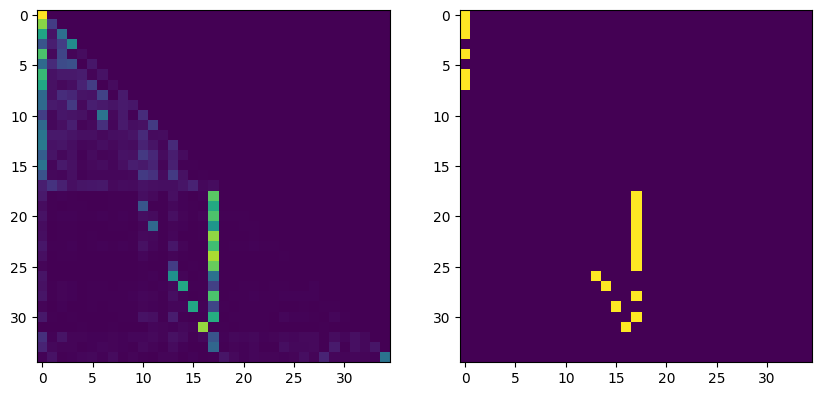

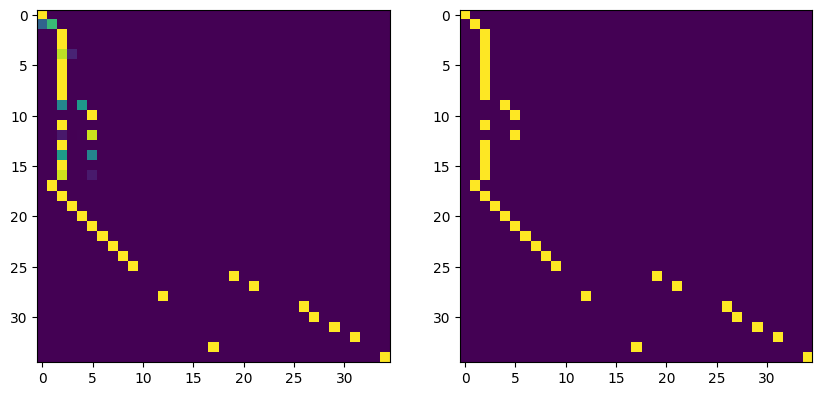

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn0)
axes[1].imshow(attn0 > .5)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn1)
axes[1].imshow(attn1 > .5)